In [1]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
EMBEDDING_DIM = 64
MAX_SEQ_LENGTH = 64
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
def build_vocab(text_columns):
    vocab = {'<pad>': 0, '<unk>': 1, '<sep>': 2}
    index = 3
    for col in text_columns:
        for text in df[col]:
            for word in str(text).split():
                if word not in vocab:
                    vocab[word] = index
                    index += 1
    return vocab

# Custom Dataset

In [5]:
class URLDataset(Dataset):
    def __init__(self, texts, numerical_features, labels, vocab, max_length):
        # Convert text columns to numpy arrays to avoid pandas indexing issues
        self.texts = {col: texts[col].values for col in text_columns}
        self.numerical = numerical_features
        self.labels = labels
        self.vocab = vocab
        self.max_length = max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Process text components using direct array access
        combined_text = ' <sep> '.join([str(self.texts[col][idx]) for col in text_columns])
        tokenized = [self.vocab.get(word, 0) for word in combined_text.split()[:self.max_length]]
        padded = tokenized + [0]*(self.max_length - len(tokenized))
        
        return {
            'text': torch.LongTensor(padded),
            'numerical': torch.FloatTensor(self.numerical[idx]),
            'label': torch.LongTensor([self.labels[idx]])
        }

# Custom ANN Model

In [6]:
class URLClassifierANN(nn.Module):
    def __init__(self, vocab_size, num_numerical_features, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, EMBEDDING_DIM)
        self.fc = nn.Sequential(
            nn.Linear(EMBEDDING_DIM + num_numerical_features, 16),
            nn.BatchNorm1d(16), 
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.Linear(16, num_classes)
        )

    def forward(self, text, numerical):
        embedded = self.embedding(text).mean(dim=1)  # Average pooling
        combined = torch.cat([embedded, numerical], dim=1)
        return self.fc(combined)

# Custom CNN Model

In [7]:
class URLClassifierCNN(nn.Module):
    def __init__(self, vocab_size, num_numerical_features, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, EMBEDDING_DIM)

        self.conv = nn.Sequential(
            nn.Conv1d(EMBEDDING_DIM, 64, kernel_size=3),
            nn.BatchNorm1d(64),  # Normalize conv outputs
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.3)  # Regularization
        )

        self.fc = nn.Sequential(
            nn.Linear(64 * ((MAX_SEQ_LENGTH - 2) // 2) + num_numerical_features, 32),  # Dynamic size
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, num_classes)
        )

    def forward(self, text, numerical):
        embedded = self.embedding(text).permute(0, 2, 1)  # (batch, channels, seq_len)
        conv_out = self.conv(embedded).flatten(start_dim=1)
        combined = torch.cat([conv_out, numerical], dim=1)
        return self.fc(combined)

# Custom LSTM Model

In [8]:
class URLClassifierLSTM(nn.Module):
    def __init__(self, vocab_size, num_numerical_features, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, EMBEDDING_DIM)
        self.lstm = nn.LSTM(EMBEDDING_DIM, 64, bidirectional=True, batch_first=True, dropout=0.3)  # Dropout between LSTM layers
        self.fc = nn.Sequential(
            nn.Linear(128 + num_numerical_features, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),  # Stronger regularization in FC layer
            nn.Linear(64, num_classes)
        )

    def forward(self, text, numerical):
        embedded = self.embedding(text)
        lstm_out, (h_n, c_n) = self.lstm(embedded)
        lstm_features = torch.cat([h_n[-2], h_n[-1]], dim=1)  # Get last hidden states
        combined = torch.cat([lstm_features, numerical], dim=1)
        return self.fc(combined)

# Training Code

In [9]:
def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    scheduler=None,
    epochs=10,
    early_stop_patience=3,
    best_checkpoint_path="./Models/best_model.pth"
):
    """
    Train and validate a model with metrics tracking, checkpointing, and early stopping
    
    Args:
        model: PyTorch model to train
        train_loader: Training data loader
        val_loader: Validation data loader
        optimizer: Optimizer instance
        criterion: Loss function
        device: Target device (cpu/cuda)
        scheduler: Learning rate scheduler (optional)
        epochs: Maximum number of epochs
        early_stop_patience: Early stopping patience
        best_checkpoint_path: Path to save best model
        last_checkpoint_path: Path to save last model
    
    Returns:
        Dictionary containing training metrics
    """
    
    # Initialize metrics tracking
    metrics = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'train_f1': [],
        'val_f1': []
    }
    
    best_f1 = 0.0
    stop_count = 0
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0.0
        train_preds, train_labels = [], []
        
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1} Training'):
            
            optimizer.zero_grad()
            outputs = model(batch['text'].to(device), batch['numerical'].to(device))
            loss = criterion(outputs, batch['label'].squeeze().to(device))
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            preds = torch.argmax(torch.softmax(outputs, dim=-1), dim=-1)
            
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(batch['label'].squeeze().cpu().numpy())
        
        # Update scheduler if provided
        if scheduler:
            scheduler.step()
            
        # Calculate training metrics
        train_loss = epoch_train_loss / len(train_loader)
        train_acc = accuracy_score(train_labels, train_preds) * 100
        train_f1 = f1_score(train_labels, train_preds, average='weighted') * 100
        
        metrics['train_loss'].append(train_loss)
        metrics['train_acc'].append(train_acc)
        metrics['train_f1'].append(train_f1)
        
        # Validation phase
        model.eval()
        epoch_val_loss = 0.0
        val_preds, val_labels = [], []
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f'Epoch {epoch+1} Validation'):
                
                outputs = model(batch['text'].unsqueeze(0).to(device), batch['numerical'].unsqueeze(0).to(device))
                loss = criterion(outputs, batch['label'].to(device))
                
                epoch_val_loss += loss.item()
                preds = torch.argmax(torch.softmax(outputs, dim=-1), dim=-1)
                
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(batch['label'].cpu().numpy())
        
        # Calculate validation metrics
        val_loss = epoch_val_loss / len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds) * 100
        val_f1 = f1_score(val_labels, val_preds, average='weighted') * 100
        
        metrics['val_loss'].append(val_loss)
        metrics['val_acc'].append(val_acc)
        metrics['val_f1'].append(val_f1)
        
        # Print epoch summary
        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
        print(f"Train F1: {train_f1:.2f}% | Val F1: {val_f1:.2f}%")
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), best_checkpoint_path)
            print(f"New best model saved with Val F1: {best_f1:.2f}%")
            stop_count = 0
        else:
            stop_count += 1
            if stop_count >= early_stop_patience:
                print(f"\nEarly stopping triggered after {epoch+1} epochs!")
                break
    
    print(f"\nTraining completed. Best Validation F1: {best_f1:.2f}%")
    return metrics

In [10]:
df = pd.read_csv('./Data/Balanced_dataset.csv')
df.head()

,url,type,scheme,domain,subdomain,top_level_domain,path,path_length,num_path_segments,query_params,num_query_params,has_https,file_extension,has_fragment,has_special_chars_in_path,has_port,port_number,is_ip_address
0,https://ethnicelebs.com/eddie-anderson-comedian,benign,https,ethnicelebs.com,none,com,/eddie-anderson-comedian,24,1,0,0,1,none,0,0,0,0,0
1,https://closinglogos.com/page/Sony+Pictures+Ho...,benign,https,closinglogos.com,none,com,/page/Sony+Pictures+Home+Entertainment+Warning...,53,2,0,0,1,none,0,0,0,0,0
2,https://terezowens.com/golfer-greg-norman-tryi...,benign,https,terezowens.com,none,com,/golfer-greg-norman-trying-to-unload-55-millio...,54,1,0,0,1,none,0,0,0,0,0
3,https://americannortel.com/,benign,https,americannortel.com,none,com,/,1,0,0,0,1,none,0,0,0,0,0
4,https://welding.org/,benign,https,welding.org,none,org,/,1,0,0,0,1,none,0,0,0,0,0


In [11]:
text_columns = ['url', 'domain', 'path', 'subdomain', 'top_level_domain']
numerical_columns = ['path_length', 'num_path_segments', 'query_params', 
                   'num_query_params', 'has_https', 'has_fragment',
                   'has_special_chars_in_path', 'has_port', 'port_number', 'is_ip_address']

# Encode labels
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])

# Normalize numerical features
scaler = StandardScaler()
numerical_features = scaler.fit_transform(df[numerical_columns])

# Build vocabulary
vocab = build_vocab(text_columns)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    np.arange(len(df)), df['type'].values, test_size=0.2, random_state=42
)

# Create datasets with corrected text handling
train_dataset = URLDataset(
    texts={col: df[col].iloc[X_train] for col in text_columns},
    numerical_features=numerical_features[X_train],
    labels=y_train,
    vocab=vocab,
    max_length=MAX_SEQ_LENGTH
)

test_dataset = URLDataset(
    texts={col: df[col].iloc[X_test] for col in text_columns},
    numerical_features=numerical_features[X_test],
    labels=y_test,
    vocab=vocab,
    max_length=MAX_SEQ_LENGTH
)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Initialize models
num_classes = len(le.classes_)

In [12]:
train_dataset[7]

{'text': tensor([ 24769,      2,  61004,      2,  71859,      2, 103097,      2, 107135,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0]),
 'numerical': tensor([-1.0340, -1.4405, -0.4953, -0.4938,  1.1876, -0.0281, -0.1577, -0.2087,
         -0.2002, -0.2459]),
 'label': tensor([3])}

In [13]:
ann_model = URLClassifierANN(len(vocab), len(numerical_columns), num_classes)
optimizer = torch.optim.Adam(ann_model.parameters(), lr=0.0009)
criterion = torch.nn.CrossEntropyLoss()

ann_model.to(DEVICE)

# Train the model
metrics = train_model(
    model=ann_model,
    train_loader=train_loader,
    val_loader=test_dataset,
    optimizer=optimizer,
    criterion=criterion,
    device=DEVICE,
    epochs=20,
    early_stop_patience=5,
    best_checkpoint_path="./Models/best_ann.pth",
)

Epoch 1 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1657.51it/s]



Epoch 1/20
Train Loss: 0.7516 | Val Loss: 0.4498
Train Acc: 73.09% | Val Acc: 83.52%
Train F1: 72.72% | Val F1: 83.18%
New best model saved with Val F1: 83.18%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1671.41it/s]



Epoch 2/20
Train Loss: 0.4883 | Val Loss: 0.3751
Train Acc: 83.00% | Val Acc: 86.33%
Train F1: 82.86% | Val F1: 86.33%
New best model saved with Val F1: 86.33%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1673.93it/s]



Epoch 3/20
Train Loss: 0.4009 | Val Loss: 0.3482
Train Acc: 86.31% | Val Acc: 87.11%
Train F1: 86.26% | Val F1: 87.10%
New best model saved with Val F1: 87.10%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1670.13it/s]



Epoch 4/20
Train Loss: 0.3352 | Val Loss: 0.3360
Train Acc: 88.65% | Val Acc: 87.74%
Train F1: 88.62% | Val F1: 87.67%
New best model saved with Val F1: 87.67%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1666.93it/s]



Epoch 5/20
Train Loss: 0.2714 | Val Loss: 0.3348
Train Acc: 91.29% | Val Acc: 87.74%
Train F1: 91.28% | Val F1: 87.79%
New best model saved with Val F1: 87.79%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1675.71it/s]



Epoch 6/20
Train Loss: 0.2170 | Val Loss: 0.3585
Train Acc: 93.13% | Val Acc: 87.69%
Train F1: 93.12% | Val F1: 87.77%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1685.23it/s]



Epoch 7/20
Train Loss: 0.1701 | Val Loss: 0.3794
Train Acc: 94.70% | Val Acc: 87.79%
Train F1: 94.70% | Val F1: 87.82%
New best model saved with Val F1: 87.82%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1674.06it/s]



Epoch 8/20
Train Loss: 0.1354 | Val Loss: 0.4236
Train Acc: 95.97% | Val Acc: 87.64%
Train F1: 95.97% | Val F1: 87.67%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1678.23it/s]



Epoch 9/20
Train Loss: 0.1034 | Val Loss: 0.4653
Train Acc: 96.97% | Val Acc: 86.68%
Train F1: 96.97% | Val F1: 86.69%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1677.82it/s]



Epoch 10/20
Train Loss: 0.0802 | Val Loss: 0.4981
Train Acc: 97.68% | Val Acc: 87.11%
Train F1: 97.68% | Val F1: 87.15%


Epoch 11 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1679.07it/s]



Epoch 11/20
Train Loss: 0.0651 | Val Loss: 0.5694
Train Acc: 98.07% | Val Acc: 87.06%
Train F1: 98.07% | Val F1: 86.95%


Epoch 12 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1679.30it/s]


Epoch 12/20
Train Loss: 0.0547 | Val Loss: 0.5762
Train Acc: 98.31% | Val Acc: 87.61%
Train F1: 98.31% | Val F1: 87.45%

Early stopping triggered after 12 epochs!

Training completed. Best Validation F1: 87.82%


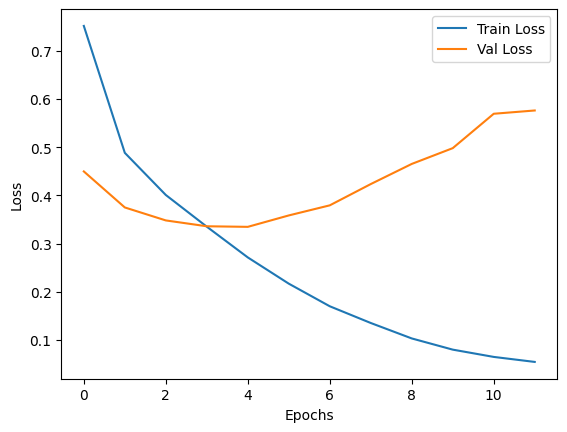

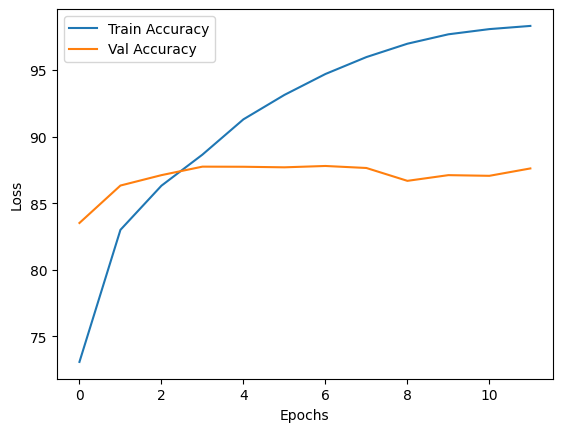

In [14]:
plt.plot(metrics['train_loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(metrics['train_acc'], label='Train Accuracy')
plt.plot(metrics['val_acc'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
cnn_model = URLClassifierCNN(len(vocab), len(numerical_columns), num_classes)
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

cnn_model.to(DEVICE)

# Train the model
metrics = train_model(
    model=cnn_model,
    train_loader=train_loader,
    val_loader=test_dataset,
    optimizer=optimizer,
    criterion=criterion,
    device=DEVICE,
    epochs=20,
    early_stop_patience=5,
    best_checkpoint_path="./Models/best_cnn.pth",
)

Epoch 1 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:10<00:00, 1158.27it/s]



Epoch 1/20
Train Loss: 0.9882 | Val Loss: 0.6394
Train Acc: 65.26% | Val Acc: 81.12%
Train F1: 65.15% | Val F1: 80.91%
New best model saved with Val F1: 80.91%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:10<00:00, 1166.36it/s]



Epoch 2/20
Train Loss: 0.6582 | Val Loss: 0.4505
Train Acc: 78.06% | Val Acc: 83.95%
Train F1: 77.80% | Val F1: 83.72%
New best model saved with Val F1: 83.72%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:10<00:00, 1167.95it/s]



Epoch 3/20
Train Loss: 0.5491 | Val Loss: 0.4016
Train Acc: 81.03% | Val Acc: 84.96%
Train F1: 80.79% | Val F1: 84.76%
New best model saved with Val F1: 84.76%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:10<00:00, 1171.66it/s]



Epoch 4/20
Train Loss: 0.5024 | Val Loss: 0.3808
Train Acc: 82.15% | Val Acc: 85.54%
Train F1: 81.93% | Val F1: 85.41%
New best model saved with Val F1: 85.41%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:10<00:00, 1171.67it/s]



Epoch 5/20
Train Loss: 0.4690 | Val Loss: 0.3643
Train Acc: 83.00% | Val Acc: 86.08%
Train F1: 82.79% | Val F1: 85.97%
New best model saved with Val F1: 85.97%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:10<00:00, 1168.02it/s]



Epoch 6/20
Train Loss: 0.4483 | Val Loss: 0.3517
Train Acc: 83.61% | Val Acc: 86.49%
Train F1: 83.42% | Val F1: 86.44%
New best model saved with Val F1: 86.44%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:10<00:00, 1171.67it/s]



Epoch 7/20
Train Loss: 0.4260 | Val Loss: 0.3461
Train Acc: 84.41% | Val Acc: 86.54%
Train F1: 84.25% | Val F1: 86.48%
New best model saved with Val F1: 86.48%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:10<00:00, 1168.32it/s]



Epoch 8/20
Train Loss: 0.4122 | Val Loss: 0.3377
Train Acc: 84.93% | Val Acc: 87.09%
Train F1: 84.80% | Val F1: 87.05%
New best model saved with Val F1: 87.05%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:10<00:00, 1168.08it/s]



Epoch 9/20
Train Loss: 0.4024 | Val Loss: 0.3286
Train Acc: 85.38% | Val Acc: 87.38%
Train F1: 85.26% | Val F1: 87.34%
New best model saved with Val F1: 87.34%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:10<00:00, 1168.48it/s]



Epoch 10/20
Train Loss: 0.3897 | Val Loss: 0.3253
Train Acc: 85.59% | Val Acc: 87.33%
Train F1: 85.48% | Val F1: 87.27%


Epoch 11 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:10<00:00, 1158.37it/s]



Epoch 11/20
Train Loss: 0.3802 | Val Loss: 0.3183
Train Acc: 86.19% | Val Acc: 87.65%
Train F1: 86.10% | Val F1: 87.57%
New best model saved with Val F1: 87.57%


Epoch 12 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:10<00:00, 1169.83it/s]



Epoch 12/20
Train Loss: 0.3688 | Val Loss: 0.3114
Train Acc: 86.57% | Val Acc: 88.36%
Train F1: 86.47% | Val F1: 88.31%
New best model saved with Val F1: 88.31%


Epoch 13 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:10<00:00, 1169.75it/s]



Epoch 13/20
Train Loss: 0.3648 | Val Loss: 0.3092
Train Acc: 86.59% | Val Acc: 88.10%
Train F1: 86.51% | Val F1: 88.07%


Epoch 14 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:10<00:00, 1162.14it/s]



Epoch 14/20
Train Loss: 0.3551 | Val Loss: 0.3144
Train Acc: 87.10% | Val Acc: 87.64%
Train F1: 87.01% | Val F1: 87.56%


Epoch 15 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:10<00:00, 1155.15it/s]



Epoch 15/20
Train Loss: 0.3483 | Val Loss: 0.3048
Train Acc: 87.46% | Val Acc: 88.26%
Train F1: 87.40% | Val F1: 88.15%


Epoch 16 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:10<00:00, 1159.71it/s]



Epoch 16/20
Train Loss: 0.3404 | Val Loss: 0.2978
Train Acc: 87.78% | Val Acc: 88.52%
Train F1: 87.73% | Val F1: 88.49%
New best model saved with Val F1: 88.49%


Epoch 17 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:10<00:00, 1167.93it/s]



Epoch 17/20
Train Loss: 0.3316 | Val Loss: 0.2992
Train Acc: 87.83% | Val Acc: 88.49%
Train F1: 87.77% | Val F1: 88.46%


Epoch 18 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:10<00:00, 1154.35it/s]



Epoch 18/20
Train Loss: 0.3279 | Val Loss: 0.2949
Train Acc: 87.98% | Val Acc: 88.57%
Train F1: 87.93% | Val F1: 88.49%


Epoch 19 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:10<00:00, 1160.68it/s]



Epoch 19/20
Train Loss: 0.3225 | Val Loss: 0.2914
Train Acc: 88.31% | Val Acc: 88.79%
Train F1: 88.27% | Val F1: 88.81%
New best model saved with Val F1: 88.81%


Epoch 20 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:10<00:00, 1167.60it/s]


Epoch 20/20
Train Loss: 0.3142 | Val Loss: 0.2967
Train Acc: 88.57% | Val Acc: 88.52%
Train F1: 88.53% | Val F1: 88.55%

Training completed. Best Validation F1: 88.81%


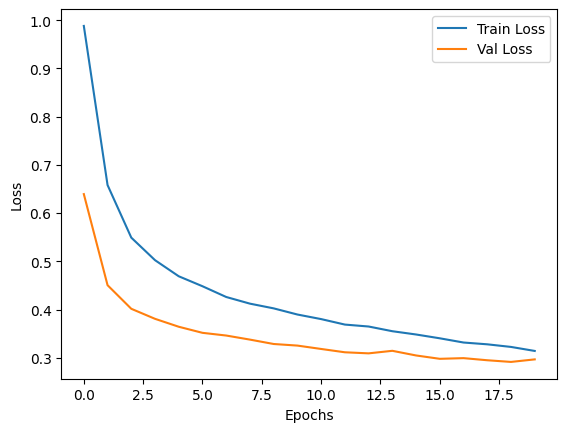

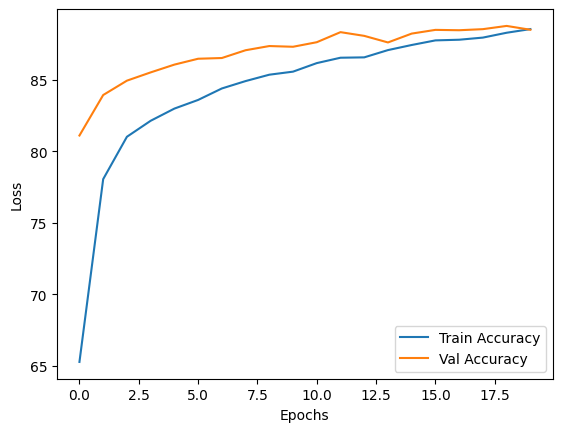

In [17]:
plt.plot(metrics['train_loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(metrics['train_acc'], label='Train Accuracy')
plt.plot(metrics['val_acc'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
lstm_model = URLClassifierLSTM(len(vocab), len(numerical_columns), num_classes)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

lstm_model.to(DEVICE)

# Train the model
metrics = train_model(
    model=lstm_model,
    train_loader=train_loader,
    val_loader=test_dataset,
    optimizer=optimizer,
    criterion=criterion,
    device=DEVICE,
    epochs=20,
    early_stop_patience=5,
    best_checkpoint_path="./Models/best_lstm.pth",
)

C:\Users\syeda\miniconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(
Epoch 1 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1314.81it/s]



Epoch 1/20
Train Loss: 1.0593 | Val Loss: 0.5786
Train Acc: 59.84% | Val Acc: 80.44%
Train F1: 59.70% | Val F1: 80.05%
New best model saved with Val F1: 80.05%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1322.07it/s]



Epoch 2/20
Train Loss: 0.5544 | Val Loss: 0.4377
Train Acc: 81.23% | Val Acc: 83.80%
Train F1: 80.97% | Val F1: 83.66%
New best model saved with Val F1: 83.66%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1316.69it/s]



Epoch 3/20
Train Loss: 0.4706 | Val Loss: 0.4041
Train Acc: 83.46% | Val Acc: 85.02%
Train F1: 83.31% | Val F1: 84.99%
New best model saved with Val F1: 84.99%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1318.56it/s]



Epoch 4/20
Train Loss: 0.4277 | Val Loss: 0.3743
Train Acc: 84.50% | Val Acc: 85.56%
Train F1: 84.41% | Val F1: 85.52%
New best model saved with Val F1: 85.52%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1316.03it/s]



Epoch 5/20
Train Loss: 0.4008 | Val Loss: 0.3616
Train Acc: 85.35% | Val Acc: 85.86%
Train F1: 85.30% | Val F1: 85.85%
New best model saved with Val F1: 85.85%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1312.85it/s]



Epoch 6/20
Train Loss: 0.3799 | Val Loss: 0.3499
Train Acc: 85.90% | Val Acc: 86.28%
Train F1: 85.87% | Val F1: 86.29%
New best model saved with Val F1: 86.29%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1316.23it/s]



Epoch 7/20
Train Loss: 0.3669 | Val Loss: 0.3577
Train Acc: 86.38% | Val Acc: 85.95%
Train F1: 86.37% | Val F1: 86.18%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1299.74it/s]



Epoch 8/20
Train Loss: 0.3492 | Val Loss: 0.3362
Train Acc: 87.15% | Val Acc: 86.65%
Train F1: 87.16% | Val F1: 86.72%
New best model saved with Val F1: 86.72%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1301.33it/s]



Epoch 9/20
Train Loss: 0.3405 | Val Loss: 0.3332
Train Acc: 87.46% | Val Acc: 86.65%
Train F1: 87.48% | Val F1: 86.60%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1310.05it/s]



Epoch 10/20
Train Loss: 0.3217 | Val Loss: 0.3256
Train Acc: 88.13% | Val Acc: 87.30%
Train F1: 88.15% | Val F1: 87.43%
New best model saved with Val F1: 87.43%


Epoch 11 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1301.51it/s]



Epoch 11/20
Train Loss: 0.3113 | Val Loss: 0.3264
Train Acc: 88.50% | Val Acc: 87.00%
Train F1: 88.51% | Val F1: 87.13%


Epoch 12 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1319.28it/s]



Epoch 12/20
Train Loss: 0.2958 | Val Loss: 0.3197
Train Acc: 88.98% | Val Acc: 87.52%
Train F1: 89.01% | Val F1: 87.54%
New best model saved with Val F1: 87.54%


Epoch 13 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1316.83it/s]



Epoch 13/20
Train Loss: 0.2847 | Val Loss: 0.3175
Train Acc: 89.44% | Val Acc: 87.34%
Train F1: 89.45% | Val F1: 87.46%


Epoch 14 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1323.84it/s]



Epoch 14/20
Train Loss: 0.2744 | Val Loss: 0.3152
Train Acc: 89.91% | Val Acc: 87.89%
Train F1: 89.93% | Val F1: 87.98%
New best model saved with Val F1: 87.98%


Epoch 15 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1316.69it/s]



Epoch 15/20
Train Loss: 0.2640 | Val Loss: 0.3137
Train Acc: 90.34% | Val Acc: 87.60%
Train F1: 90.37% | Val F1: 87.71%


Epoch 16 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1320.02it/s]



Epoch 16/20
Train Loss: 0.2514 | Val Loss: 0.3140
Train Acc: 90.77% | Val Acc: 87.97%
Train F1: 90.80% | Val F1: 87.99%
New best model saved with Val F1: 87.99%


Epoch 17 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1316.08it/s]



Epoch 17/20
Train Loss: 0.2413 | Val Loss: 0.3149
Train Acc: 91.24% | Val Acc: 88.16%
Train F1: 91.27% | Val F1: 88.18%
New best model saved with Val F1: 88.18%


Epoch 18 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1322.65it/s]



Epoch 18/20
Train Loss: 0.2301 | Val Loss: 0.3114
Train Acc: 91.58% | Val Acc: 88.15%
Train F1: 91.60% | Val F1: 88.22%
New best model saved with Val F1: 88.22%


Epoch 19 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1318.82it/s]



Epoch 19/20
Train Loss: 0.2229 | Val Loss: 0.3220
Train Acc: 91.79% | Val Acc: 88.31%
Train F1: 91.81% | Val F1: 88.30%
New best model saved with Val F1: 88.30%


Epoch 20 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1309.16it/s]


Epoch 20/20
Train Loss: 0.2113 | Val Loss: 0.3152
Train Acc: 92.27% | Val Acc: 87.96%
Train F1: 92.29% | Val F1: 88.09%

Training completed. Best Validation F1: 88.30%


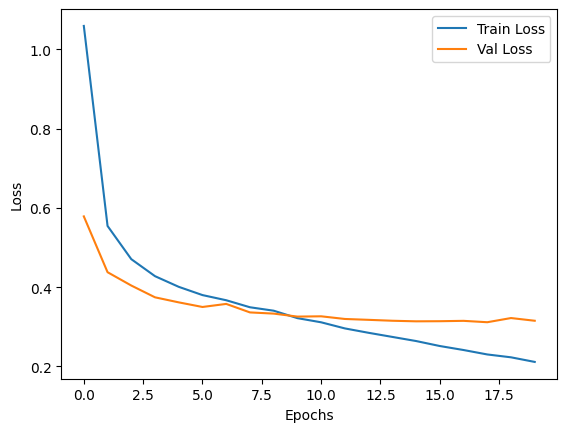

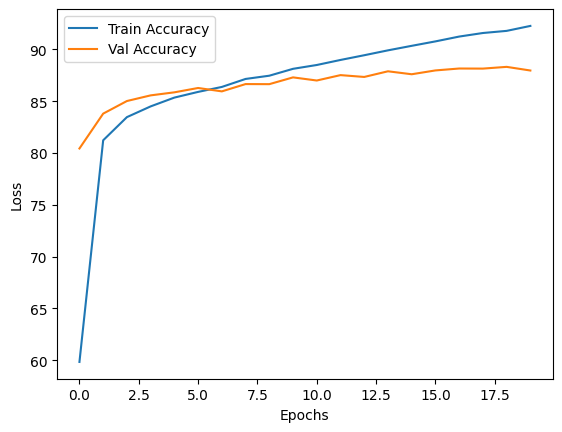

In [19]:
plt.plot(metrics['train_loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(metrics['train_acc'], label='Train Accuracy')
plt.plot(metrics['val_acc'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
for i in test_dataset:
    print(i)
    break

{'text': tensor([ 24857,      2,  61074,      2,  87550,      2, 105126,      2, 103772,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0]), 'numerical': tensor([ 0.5187, -0.0902, -0.4953, -0.4938,  1.1876, -0.0281, -0.1577, -0.2087,
        -0.2002, -0.2459]), 'label': tensor([3])}


# With word2vec

In [21]:
# 1. Train Word2Vec embeddings
def train_word2vec(text_columns, vector_size=100, window=5, min_count=1):
    # Create training corpus
    sentences = []
    for col in text_columns:
        sentences += [str(text).split() for text in df[col]]
    
    # Train Word2Vec model
    model = Word2Vec(sentences=sentences,
                     vector_size=vector_size,
                     window=window,
                     min_count=min_count,
                     workers=4)
    return model

# 2. Create embedding matrix
def create_embedding_matrix(word2vec_model, vocab):
    embedding_dim = word2vec_model.vector_size
    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    
    for word, idx in vocab.items():
        if word in word2vec_model.wv:
            embedding_matrix[idx] = word2vec_model.wv[word]
        else:
            # Handle unknown words (random initialization with scaling)
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))
    
    return torch.FloatTensor(embedding_matrix)

In [22]:
class URLClassifierW2V(nn.Module):
    def __init__(self, embedding_matrix, num_numerical_features, num_classes):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.fc = nn.Sequential(
            nn.Linear(embedding_matrix.size(1) + num_numerical_features, 128),
            nn.BatchNorm1d(128), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, text, numerical):
        embedded = self.embedding(text).mean(dim=1)
        combined = torch.cat([embedded, numerical], dim=1)
        return self.fc(combined)

In [23]:
# Train Word2Vec
w2v_model = train_word2vec(text_columns)

# Create embedding matrix
embedding_matrix = create_embedding_matrix(w2v_model, vocab)

In [24]:
# Initialize models with Word2Vec embeddings
w2v_ann_model = URLClassifierW2V(embedding_matrix, len(numerical_columns), num_classes)
# train_model(w2v_ann_model, train_loader, test_loader)

optimizer = torch.optim.Adam(w2v_ann_model.parameters())
criterion = torch.nn.CrossEntropyLoss()

w2v_ann_model.to(DEVICE)

metrics = train_model(
    model=w2v_ann_model,
    train_loader=train_loader,
    val_loader=test_dataset,
    optimizer=optimizer,
    criterion=criterion,
    device=DEVICE,
    epochs=20,
    early_stop_patience=5,
    best_checkpoint_path="./Models/best_w2v_ann.pth",
)

Epoch 1 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1686.26it/s]



Epoch 1/20
Train Loss: 0.4614 | Val Loss: 0.2567
Train Acc: 82.84% | Val Acc: 90.59%
Train F1: 82.74% | Val F1: 90.68%
New best model saved with Val F1: 90.68%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1693.88it/s]



Epoch 2/20
Train Loss: 0.1299 | Val Loss: 0.1935
Train Acc: 95.66% | Val Acc: 92.57%
Train F1: 95.66% | Val F1: 92.62%
New best model saved with Val F1: 92.62%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1689.65it/s]



Epoch 3/20
Train Loss: 0.0326 | Val Loss: 0.2422
Train Acc: 99.06% | Val Acc: 92.56%
Train F1: 99.06% | Val F1: 92.60%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1690.54it/s]



Epoch 4/20
Train Loss: 0.0189 | Val Loss: 0.2681
Train Acc: 99.46% | Val Acc: 92.61%
Train F1: 99.46% | Val F1: 92.64%
New best model saved with Val F1: 92.64%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1688.76it/s]



Epoch 5/20
Train Loss: 0.0167 | Val Loss: 0.2830
Train Acc: 99.51% | Val Acc: 93.04%
Train F1: 99.51% | Val F1: 93.10%
New best model saved with Val F1: 93.10%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1685.65it/s]



Epoch 6/20
Train Loss: 0.0094 | Val Loss: 0.3010
Train Acc: 99.69% | Val Acc: 92.11%
Train F1: 99.69% | Val F1: 92.07%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1682.18it/s]



Epoch 7/20
Train Loss: 0.0128 | Val Loss: 0.3296
Train Acc: 99.58% | Val Acc: 92.59%
Train F1: 99.58% | Val F1: 92.64%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1683.97it/s]



Epoch 8/20
Train Loss: 0.0102 | Val Loss: 0.4012
Train Acc: 99.66% | Val Acc: 92.46%
Train F1: 99.66% | Val F1: 92.52%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1677.61it/s]



Epoch 9/20
Train Loss: 0.0107 | Val Loss: 0.3442
Train Acc: 99.65% | Val Acc: 92.74%
Train F1: 99.65% | Val F1: 92.82%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1683.08it/s]


Epoch 10/20
Train Loss: 0.0090 | Val Loss: 0.4672
Train Acc: 99.70% | Val Acc: 91.58%
Train F1: 99.70% | Val F1: 91.50%

Early stopping triggered after 10 epochs!

Training completed. Best Validation F1: 93.10%


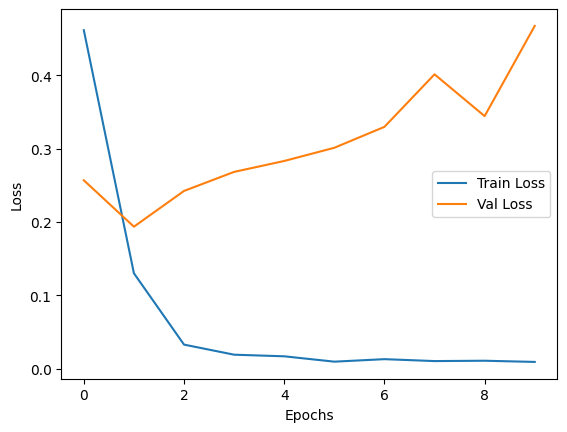

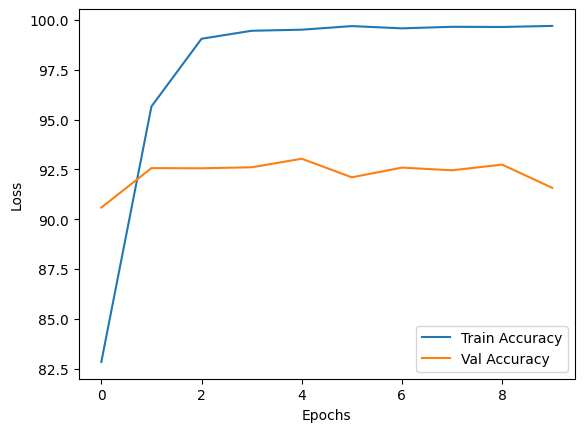

In [25]:
plt.plot(metrics['train_loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(metrics['train_acc'], label='Train Accuracy')
plt.plot(metrics['val_acc'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
class URLClassifierW2VCNN(nn.Module):
    def __init__(self, vocab_size, num_numerical_features, num_classes):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

        self.conv = nn.Sequential(
            nn.Conv1d(EMBEDDING_DIM, 64, kernel_size=3),
            nn.BatchNorm1d(64),  # Normalize conv outputs
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.3)  # Regularization
        )

        self.fc = nn.Sequential(
            nn.Linear(64 * ((MAX_SEQ_LENGTH - 2) // 2) + num_numerical_features, 32),  # Dynamic size
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, num_classes)
        )

    def forward(self, text, numerical):
        embedded = self.embedding(text).permute(0, 2, 1)  # (batch, channels, seq_len)
        conv_out = self.conv(embedded).flatten(start_dim=1)
        combined = torch.cat([conv_out, numerical], dim=1)
        return self.fc(combined)

In [27]:
w2v_cnn_model = URLClassifierW2VCNN(embedding_matrix, len(numerical_columns), num_classes)

optimizer = torch.optim.Adam(w2v_cnn_model.parameters())
criterion = torch.nn.CrossEntropyLoss()

w2v_cnn_model.to(DEVICE)

metrics = train_model(
    model=w2v_ann_model,
    train_loader=train_loader,
    val_loader=test_dataset,
    optimizer=optimizer,
    criterion=criterion,
    device=DEVICE,
    epochs=20,
    early_stop_patience=5,
    best_checkpoint_path="./Models/best_w2v_cnn.pth",
)

Epoch 1 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1632.55it/s]



Epoch 1/20
Train Loss: 0.0152 | Val Loss: 0.4790
Train Acc: 99.58% | Val Acc: 91.06%
Train F1: 99.58% | Val F1: 90.89%
New best model saved with Val F1: 90.89%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1632.72it/s]



Epoch 2/20
Train Loss: 0.0160 | Val Loss: 0.4533
Train Acc: 99.49% | Val Acc: 91.62%
Train F1: 99.49% | Val F1: 91.53%
New best model saved with Val F1: 91.53%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1635.50it/s]



Epoch 3/20
Train Loss: 0.0150 | Val Loss: 0.4788
Train Acc: 99.56% | Val Acc: 91.13%
Train F1: 99.56% | Val F1: 90.99%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1637.22it/s]



Epoch 4/20
Train Loss: 0.0136 | Val Loss: 0.4173
Train Acc: 99.58% | Val Acc: 91.95%
Train F1: 99.58% | Val F1: 91.92%
New best model saved with Val F1: 91.92%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1635.96it/s]



Epoch 5/20
Train Loss: 0.0140 | Val Loss: 0.4900
Train Acc: 99.55% | Val Acc: 91.23%
Train F1: 99.55% | Val F1: 91.08%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1639.52it/s]



Epoch 6/20
Train Loss: 0.0124 | Val Loss: 0.4278
Train Acc: 99.63% | Val Acc: 91.53%
Train F1: 99.63% | Val F1: 91.45%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1635.63it/s]



Epoch 7/20
Train Loss: 0.0139 | Val Loss: 0.4411
Train Acc: 99.54% | Val Acc: 91.59%
Train F1: 99.54% | Val F1: 91.48%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1624.34it/s]



Epoch 8/20
Train Loss: 0.0148 | Val Loss: 0.4654
Train Acc: 99.55% | Val Acc: 91.16%
Train F1: 99.55% | Val F1: 90.99%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1624.34it/s]


Epoch 9/20
Train Loss: 0.0133 | Val Loss: 0.5088
Train Acc: 99.56% | Val Acc: 91.28%
Train F1: 99.56% | Val F1: 91.12%

Early stopping triggered after 9 epochs!

Training completed. Best Validation F1: 91.92%
